## The Exit Building Problem
In this problem, there are 6 rooms and our agent starts out in a random room. The doors between rooms can be bidirectional or directional. All transitions between rooms give 0 reward except transitions to room 5 (terminal state) which gives a reward of 100. The objective is to learn a sequence of steps to take us to the exit (room 5). Naturally, the problem can be modelled using a directed graph as shown below. We apply Q-learning to learn action-values and solve the problem.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

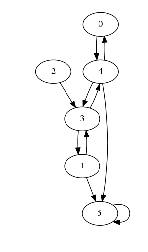

In [2]:
img = mpimg.imread('exit_building.png');
plt.axis('off')
plt.imshow(img)

In [3]:
class BuildingEnv:
    def __init__(self):
        self.nS = 6  # no. of states
        self.nA = 6  # no. of actions
        
        # A[s] is a list of actions that can be taken from state s
        A = {}
        A[0] = [4]
        A[1] = [3, 5]
        A[2] = [3]
        A[3] = [1, 4]
        A[4] = [0, 3, 5]
        A[5] = [5]
        self.A = A
        
        # Holds all possible transitions for states in the environment
        # T[s][a] is a (s', r, done) tuple
        # You will receive reward r and transition to state s' if you take
        # action a while currently in state s. Done is true if you have
        # reached the exit        
        T = {}
        exit = self.nS - 1
        for s in range(self.nS):
            T[s] = {}
            for a in A[s]:
                reward = 100 if a == exit else 0
                done = True if a == exit else False
                T[s][a] = ((a, reward, done))
        self.T = T

        
    # Resets the environment and returns the initial state
    def reset(self):
        # s is the current state
        self.s = np.random.choice(self.nS, 1)[0]
        return self.s
        
    # Executes the given action in the current state and returns
    # (s', r, done) which means you will receive reward r and transition to
    # state s' if you execute action in the current state, s. Done is true if
    # you have reached the exit
    def step(self, action):
        if not action in self.A[self.s]:
            raise ValueError('Cannot execute action %d in state %d' % (action, self.s))
        
        # Update the state based on the action taken
        obs = self.T[self.s][action]
        self.s = obs[0]
        
        return obs

In [4]:
def q_learning(env, discount_factor = 1, num_episodes=100):
    '''
    Evaluates a policy given an environment. Assumes equiprobable selection of actions
    Args:
        env: Represents the dynamics of the environment
        discount_factor: smaller values favor instantaneous reward, larger values are far-sighted
        num_episodes: the maximum number of episodes to run
        all (s,a) pairs.
    '''
    Q = np.zeros((env.nS, env.nA))
    
    for episode in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            # Select random action from set of all actions that can be taken from this state
            a = np.random.choice(env.A[s])
            
            # Execute the action and receive next state and reward
            s_, r, done = env.step(a)
            
            # Update Q(s,a) based on possible actions that can be taken from next state
            action_values = [Q[s_,a_] for a_ in env.A[s_]]
            Q[s,a] = r + discount_factor * np.max(action_values)
                
            # Go to next state
            s = s_
        
    return Q

In [5]:
env = BuildingEnv()
Q = q_learning(env, discount_factor=0.5, num_episodes=500)
print(Q)

[[   0.    0.    0.    0.  100.    0.]
 [   0.    0.    0.   50.    0.  200.]
 [   0.    0.    0.   50.    0.    0.]
 [   0.  100.    0.    0.  100.    0.]
 [  50.    0.    0.   50.    0.  200.]
 [   0.    0.    0.    0.    0.  200.]]


Since we use a random policy to learn the action-values, we run the environment several times to ensure that most transitions are executed. The task is also episodic (eventually ends, as opposed to continuous) and I have used a discount factor of 0.5. You can experiment with different values.

The results are what we expect. The best (and only) move to take from 0 is to go to 4. The best move from 1 is to go directly to 5 (notice how we can also go to 3, but that has less value). From 3, going to 1 or 4 has equal value (so we could pick randomly) and so on. 

Here is an example run to see how an agent can make decisions using these action-values:

In [12]:
s = env.reset()
states = []
done = False
while not done:
    states.append(s)
    action = np.argmax(Q[s])
    s_, r, done = env.step(action)
        
    s = s_
states.append(s)
print(" -> ".join([str(s) for s in states]))

2 -> 3 -> 1 -> 5


Although we learned the values of actions, we can also use Q-learning to learn the values of states. At each step, we would then select action that takes us to the state with the highest value. The GridWorld problem in Example 4.1 of [1] can be modeled and solved in a similar fashion.

## References
1. Richard S. Sutton, Andrew G. Barto (1998). Reinforcement Learning: An Introduction. MIT Press.